In [1]:
import pickle
import sys
sys.path.append('..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

## Training with a GPU on Amazon Web Services (AWS)

In order to improve the agent's performance, its deep Q network must be trained for a longer time and exposed to many more cubes. For comparison, the network described in Solving the Rubik’s Cube Without Human Knowledge  [1] is exposed to roughly ~8 billion shuffled cubes while the networks described in the part one notebook only saw 1000 shuffled cubes during training. An additional requirement for improved performance is larger network capacity, since more parameters allows for the network to better learn patterns for cube solving.

As it is impractical to train large networks for extended periods on my MacBook, a cloud computing solution is instead used for longer training cycles. Specifically, GPU-enabled EC2 instances from Amazon Web Services are used.

### Steps for training Rubik's cube solver on AWS

#### 1) Launch an EC2 instance

        Recommended AMI: TensorFlow from NVIDIA AMI (https://aws.amazon.com/marketplace/pp/B07S2Z9N33)
        
        Recommended Instance Type: g4dn.xlarge (one of the least-expensive GPU-enabled instance types)
        
#### 2) SSH into instance 

    ssh -i <private-key.pem> ubuntu@<instance Public DNS (IPv4)>
        
#### 3) Clone repo onto EC2 instance

    git clone https://github.com/MattD18/rubiks-cube.git 

#### 4) Pull Tensorflow v2.0 with GPU Docker Image

    docker pull tensorflow/tensorflow:2.0.0-gpu-py3
    
#### 5) Run training script on detached docker container

    docker run -v /home/ubuntu/:/home -d -w /home/rubiks-cube/scripts --gpus all -it --rm tensorflow/tensorflow:2.0.0-gpu-py3 python train.py
    
    Note: Running the training script on a detached docker container allows the user to disconnect from their ssh session with instance during training.
    
#### 7) Set-Up AWS CLI 

    sudo apt install awscli 
    aws configure
    
#### 6) Upload results to S3 bucket from repo root directory

    ./save_results.sh


### Note on spot pricing

AWS allows users to request EC2 instances at their current "spot prices" which are often substanially cheaper than the offered "on-demand" price [2]. Spot-instances consequently provide a much more cost effective resource for training models. However, since AWS has the ability to terminate a spot instance based on current demand for the instance type, the training procedure must be fault tolerant.

For the training of the Rubik's cube solver, fault tolerance during training is done by checkpointing the networks weights every 500 epochs and saving both the checkpointed weights as well as the training logs (loss and validation accuracy) to an S3 bucket every 2 hours.
        


## Improving solver with Monte Carlo Tree Search (MCTS)

In [1], the authors combine Deep Q-Learning with Monte Carlo Tree Search (MCTS) [3] to achieve impressive performance with their Rubik's cube solver. MCTS is a search algorithm that leverages the trained deep Q network and random sampling of the search space to look for a solution. 

In MCTS, the states of the Rubik's cube are represented as nodes on a tree with the initial shuffled state representing the root node. Each node can have exactly 12 child nodes, each of which represent the state of the cube after applying one of the 12 rotations to the parent node state. If a node does not have child nodes it is called a leaf node. Each node also contains a "history" that contains information about the search. Using this tree structure, MCTS searchs for a solution iteratively, with each iteration consisting of four steps: Selection, Expansion, Simulation, and Backpropagation. 

These four steps are briefly summarized at a conceptual level as follows:

**1) Selection**

Given the current state of tree succesive child nodes are "selected" (in a way that balances exploration and exploitation) until a leaf node is reached.

**2) Expansion**

If the leaf node does not represent the solved state, the 12 child nodes of the leaf node are added to the tree.

**3) Simulation**

A move from the leaf node's state to the most promising child node's state is simulated.

**4) Backpropagation**

The histories of all nodes involved in this iteration of the algorithm are updated based on the outcome of the simulation.

For a more detailed description of the Rubik's Cube MCTS method, the reader is referred to section 4.2 of [1]. The implementation used in this repo closely follows this method and can be found in the solve() method of lib.mcts.MCTS(). 

### MCTS Results

To evaluate the benefit of using MCTS, performance is compared between an agent that uses MCTS in conjunction with a deep Q network against an agent that solely uses the deep Q network and greedily takes the best action at each state. The deep Q network used in this experiment is similiar to the ones described in part 1 except this network has 3 dense layers and 3 convolutional layers instead of a single one of each. Also the network was trained for 50,000 episodes of cubes randomly shuffled 5 times on a g4dn.xlarge EC2 instance over an 82 hour period. 

The agents are assesed on cubes that have been randomly shuffled 3, 5, and 7 times, and in all cases a marked improvement is observed when using MCTS (as show below). The most interesting result is the performance of MCTS on the cubes shuffled 7 times, where solve rate improves from 20% to 49%. What is notable is that the solver is only ever exposed to cubes shuffled 5 times during training so MCTS is vastly improving performance on cubes in previously unseen states.

([<matplotlib.axis.XTick at 0x10deaa240>,
 <a list of 3 Text xticklabel objects>)

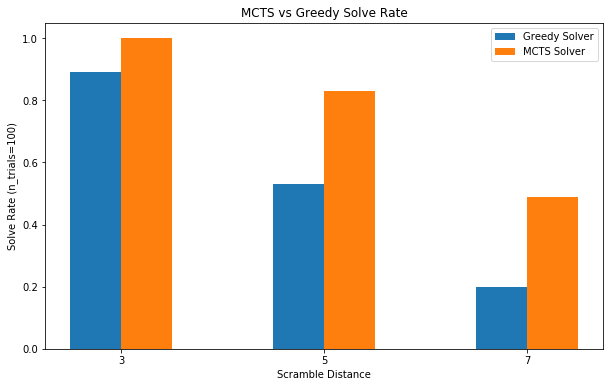

In [2]:
# load pickled mcts and greedy experiment results
with open('../results/mcts_exp_results.pickle','rb') as f:
    mcts_results = pickle.load(f)
with open('../results/greedy_exp_results.pickle','rb') as f:
    greedy_results = pickle.load(f)

plt.figure(figsize=(10,6))
# Setting the positions and width for the bars
pos = list(range(len(greedy_results))) 
width = 0.25 
plt.bar(pos, greedy_results.values(), width, label="Greedy Solver")
plt.bar([p + width for p in pos], mcts_results.values(), width,label="MCTS Solver")
plt.xlabel("Scramble Distance")
plt.ylabel("Solve Rate (n_trials=100)")
plt.title("MCTS vs Greedy Solve Rate")
plt.legend()
# Set the position of the x ticks
plt.xticks([p + .5 * width for p in pos], labels = list(greedy_results.keys()))

### MCTS Accuracy vs Time

The MCTS algorithm has no clear stopping criteria other than to stop once the solved state has been reached, so in theory the algorithm could just keep iterating forever. In practice a step or time limit must be enforced after which the algorithm terminates. The choice of this limit will effect the solve rate. In [1], the authors use a time limit of 30 minutes, however, depending on the application this time limit might need to be reduced. For example, if the solver is part of an interactive app, the limit might only be 30 seconds depending on the patience of the user. Below, we show how the solver performs as a function of step limits. 

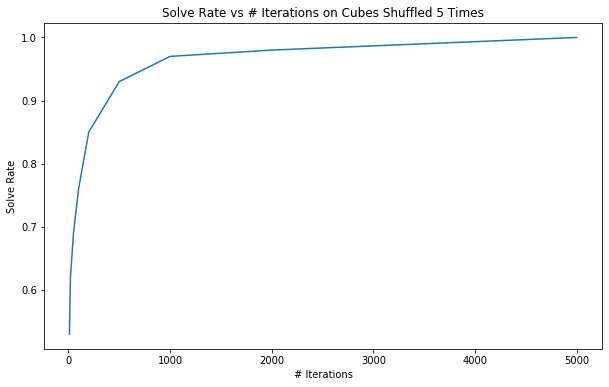

In [6]:
time_trials_df = pd.read_csv('../data/time_trials.csv')
time_trials = time_trials_df[['n_searches','solve_rate']]
n_searches = time_trials['n_searches'].values
solve_rate = time_trials['solve_rate'].values
solve_rate

plt.figure(figsize=(10,6))
plt.xlabel("# Iterations")
plt.ylabel("Solve Rate")
plt.title("Solve Rate vs # Iterations on Cubes Shuffled 5 Times")
plt.plot(n_searches,solve_rate)

### Results 

#### Model Architecture: 
Embedding Dimension: 256  
One Conv Layer with 128 Filters  
Two FC Layer (1024 dimensional and 512 dimensional)  
Regularization on all layers with l2-regularization parameter of .05  
Elu activations between layers

#### Training Params: 
Num Episodes: 200,000  
Learning Rate: 5e-06 for first 100,000 episodes then decreased to 1e-06 for second 100,000 episodes  
Exploration Strategy: Linear Decay until 0.1 at episode 10,000  
Replay Buffer Capacity: 1024  
Batch Size: 128  
Discount Factor: .9  

Note on training strategy: For each episode the agent is shown a shuffled cube of scramble distance between 1 and 15. As the reward space is very sparse for large scramble distances, the agent both has trouble finding the reward state and with temporal credit assignment. To help mitigate this issue, the scramble distance is drawn from a beta distribution such that low scramble distance cubes are shown to the agent at a greater proportion. This seems to help the agent better track the reward signal. A similiar approach to training is taken in [1] where lower scramble distance cubes are given a higher weight when calculating the lost function. 


To evaluate agent's performance, it is tasked with solving 100 shuffled cubes at a scramble distance of 1, 3, 5, 7, 9, 11, 13, and 15 in a maximum of 10,000 iterations of MCTS (~10 minutes on MacBook). The agent is able to solve cubes fairly well until a scramble distance of ~9 and then performance degrades rapidly.

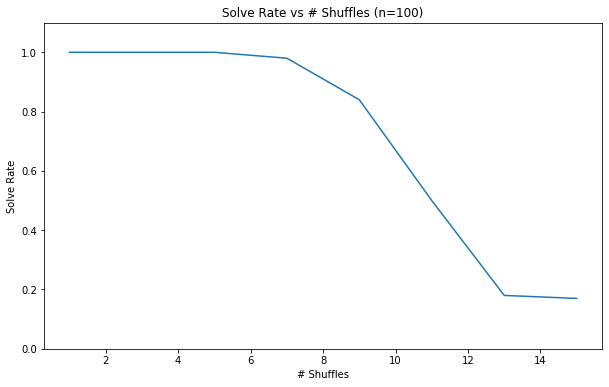

In [19]:
results_df = pd.read_csv('../results/20191224023143.csv')
results_df = results_df.sort_values('num_shuffles')
num_shuffles = results_df['num_shuffles'].values
solve_rate = results_df['solve_rate'].values

plt.figure(figsize=(10,6))
plt.xlabel("# Shuffles")
plt.ylabel("Solve Rate")
plt.title("Solve Rate vs # Shuffles (n=100)")
plt.ylim(0,1.1)
plt.plot(num_shuffles,solve_rate)


### Next Steps

To come is further training on the GPU on more scrambled cubes. 


## Sources

[1] https://arxiv.org/pdf/1805.07470.pdf

[2] https://aws.amazon.com/ec2/spot/pricing/

[3] https://en.wikipedia.org/wiki/Monte_Carlo_tree_search#Monte_Carlo_Tree_Search_(MCTS)


